In [1]:
import os
import sys
import subprocess
root = "/data/luojaa/eukgen/"
%cd {root}
sys.path.append(root)
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#import altair_saver

import ete3
from ete3 import Tree, TreeStyle, TextFace

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run /data/luojaa/eukgen/styling_and_visualisation.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

/vf/users/luojaa/eukgen


/tmp/ipykernel_277797/4185059851.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
os.environ['QT_QPA_PLATFORM']='offscreen'

### read in microcosm_dl files

In [3]:
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_tree_data.tsv.edited", sep = "\t")
leaf_mapping_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_tree_data.leaf_mapping.tsv", sep = "\t")

In [4]:
repseq_df = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"EC":"tree_name", "Query":"euk_clade_rep"})

ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")

In [5]:
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

In [6]:
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop(
    "comments", axis=1).rename(columns={"EC": "tree_name"})

In [7]:
tree_data_dl_mapped = pd.merge(tree_data_dl, repseq_df, on=["euk_clade_rep", "tree_name"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="tree_name",
                               how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")

### read in aggregate files

In [8]:
tree_data = pd.read_csv("/data/tobiassonva/data/eukgen/microcosm_tree_data.tsv.edited", sep = "\t")
leaf_mapping = pd.read_csv("/data/tobiassonva/data/eukgen/microcosm_tree_data.leaf_mapping.tsv", sep = "\t")
header_mapping = pd.read_csv("/data/tobiassonva/data/eukgen/core_data/euk72_ep/euk72_ep.fasta.header_mapping", sep = "\t", header = None)
header_mapping.rename(columns = {0: "acc", 1:"header"}, inplace = True)
header_mapping.set_index("acc", inplace = True)

/tmp/ipykernel_277797/488356322.py:1: DtypeWarning: Columns (4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data = pd.read_csv("/data/tobiassonva/data/eukgen/microcosm_tree_data.tsv.edited", sep = "\t")


In [9]:
# not all microcosms are annotated, and not all annotated clusters made it to microcosms
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)

In [10]:
# filter out unannotated microcosms
tree_data.set_index("tree_name", inplace = True)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()
leaf_mapping.set_index("tree_name", inplace = True)
leaf_mapping_annot = leaf_mapping[leaf_mapping.index.isin(annotated_clusters)]
header_mapping_annot = header_mapping[header_mapping.index.isin(set(leaf_mapping_annot.acc))]

In [11]:
# map KOG annotations to tree data
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
tree_data_important = tree_data_tophit[tree_data_tophit.euk_scope_len > 5]
tree_data_universal = tree_data_tophit[tree_data_tophit.euk_scope_len > 10]

In [12]:
# read in the kegg maps and modules
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]


In [13]:
# read in BRITE data
kog_brite = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
brite_desc = pd.read_csv("/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv", dtype=str, sep = "\t").set_index("brite_id")
kogs_w_pathway = set(pathway_data.KOGID)
kog_brite_nomap = kog_brite[~kog_brite.kogid.isin(kogs_w_pathway)].reset_index()
kog_brite_nomap["brite"] = kog_brite_nomap.brite_C.apply(lambda x: x.split("|"))
kog_brite_nomap = kog_brite_nomap.explode("brite").reset_index()

In [ ]:
brite_counts = kog_brite.brite_C.apply(lambda x: x.split("|")).explode().value_counts()
brite_nomap_counts = kog_brite_nomap.brite.value_counts()
brite_nomap_fraction = pd.merge(brite_counts,brite_nomap_counts, how = "right", left_index=True, right_index=True)
brite_nomap_fraction["fraction_missing"] = brite_nomap_fraction.count_y / brite_nomap_fraction.count_x
brite_nomap_fraction = pd.merge(brite_nomap_fraction, brite_desc, how = "left", left_index=True, right_index=True)

In [ ]:
# brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"]).iloc[:50,:]
# brite_metabolism = set(brite_b_desc[brite_b_desc.brite_A == "09100"].brite_B)

### ribosomal analysis

In [ ]:
# ribosomal structural proteins
ribosome = pathway_data[pathway_data.CATEGORY_ID == "map03010"].KOGID

In [ ]:
# ribosome biogenesis
ribosome_biogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID

In [ ]:
eukprofiles_ribosome = kegg_annot[kegg_annot.Target.isin(ribosome)]
microcosms_ribosome = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_ribosome.Query)]

In [ ]:
eukprofiles_ribosome.shape[0], len(set(microcosms_ribosome.tree_name))

which ribosome KOGs didn't find a microcosm


In [ ]:
hits_microcosms_ribosome = eukprofiles_ribosome[eukprofiles_ribosome.Query.isin(set(microcosms_ribosome.tree_name))]
KOGs_rib_inmicrocosms = set(hits_microcosms_ribosome.Target)

In [ ]:
len(KOGs_rib_inmicrocosms), len(ribosome)

In [ ]:
ribKOGs_notfound = set(ribosome).difference(KOGs_rib_inmicrocosms)

In [ ]:
# # ribosome KOGs that have no microcosms
#category_data[category_data.KOGID.isin(ribKOGs_notfound)].drop_duplicates("FUNCTION")

### translation factor analysis

In [ ]:
# translation_factors = set(initiation + elongation + release + prokaryotic_transfact)
# eukprofiles_transfac = kegg_annot[kegg_annot.Target.isin(translation_factors)]
# microcosms_transfac = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_transfac.Query)]

In [ ]:
# eukprofiles_transfac.shape[0], len(set(microcosms_transfac.tree_name))

### ribosome biogenesis analysis

In [ ]:
eukprofiles_rib_biogen = kegg_annot[kegg_annot.Target.isin(ribosome_biogen)]
microcosms_rib_biogen = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rib_biogen.Query)]

In [ ]:
eukprofiles_rib_biogen.shape[0], len(set(microcosms_rib_biogen.tree_name))

### nuclear pore complex analysis

In [ ]:
# nuclear pore
nuclear_pore = pathway_data[pathway_data.CATEGORY_ID == "map03013"].KOGID
eukprofiles_nucpore = kegg_annot[kegg_annot.Target.isin(nuclear_pore)]
microcosms_nucpore = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_nucpore.Query)]

In [ ]:
eukprofiles_nucpore.shape[0], len(set(microcosms_nucpore.tree_name))

## everything else

In [ ]:
# ribosome
tree_data_filt = tree_data_mapped[tree_data_mapped["c-ELW"] > 0]
trees = tree_data_filt[tree_data_filt["Target"].isin(ribosome)]
trees_sorted = trees.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
systems = iter(trees_sorted.iloc[30:,:].tree_name)

In [ ]:
# nuclear pore
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(nuclear_pore)]
systems = iter(trees_sorted[trees_sorted.Description.str.contains("Nup")].tree_name)


In [ ]:
# # release
# tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
# trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(release)]
# systems = iter(trees_sorted.tree_name)


In [ ]:
# aa-tRNA biosynthesis
aa_trna = pathway_data[pathway_data.CATEGORY_ID == "map00970"].KOGID
eukprofiles_aatrna = kegg_annot[kegg_annot.Target.isin(aa_trna)]
microcosms_aatrna = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_aatrna.Query)]
print(eukprofiles_aatrna.shape[0], len(set(microcosms_aatrna.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(aa_trna)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"] > .5]
systems = iter(trees_filtered.tree_name)


In [ ]:
# mRNA surveillance 
mRNAsurv = pathway_data[pathway_data.CATEGORY_ID == "map03015"].KOGID
eukprofiles_msurv = kegg_annot[kegg_annot.Target.isin(mRNAsurv)]
microcosms_msurv = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_msurv.Query)]
print(eukprofiles_msurv.shape[0], len(set(microcosms_msurv.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(mRNAsurv)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.50,1)]
systems = iter(trees_filtered.tree_name)


In [ ]:
# ribosome biogenesis 
"map03008"
rBiogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID
eukprofiles_rbg = kegg_annot[kegg_annot.Target.isin(rBiogen)]
microcosms_rbg = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rbg.Query)]
print(eukprofiles_rbg.shape[0], len(set(microcosms_rbg.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(rBiogen)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.501,.99)]
systems = iter(trees_sorted[70:].tree_name)


In [ ]:
# spliceosome 
"map03040"
splice = pathway_data[pathway_data.CATEGORY_ID == "map03040"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(splice)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(splice)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# protein export
pe = pathway_data[pathway_data.CATEGORY_ID == "map03060"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(pe)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(pe)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# ER, other (map04141)
er = set(pathway_data[pathway_data.CATEGORY_ID == "map04141"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(er)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(er)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
#to do: save to file
erad = ["K14026", "K13993", "K03283", "K06689", "K13989", "K09562", "K09542", "K13525", "K09503", "K09502", "K10575",
"K03868","K04079","K04554","K14018","K09541","K09561","K09525"]

In [ ]:
copii = ["K14003", "K07953", "K14006", "K14007", "K14004", "K14005", "K14003"]
other_er = set(trees_filtered.Target).difference(set(erad + copii))

In [ ]:
# endocytosis
endo = set(pathway_data[pathway_data.CATEGORY_ID == "map04144"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(endo)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(endo)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# SNARE interactions in vesicular transport
snare = set(pathway_data[pathway_data.CATEGORY_ID == "map04130"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(snare)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(snare)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# Ubiquitin mediated proteolysis
ump = set(pathway_data[pathway_data.CATEGORY_ID == "map04120"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(ump)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(ump)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# Sulfur transfer
sutr = set(pathway_data[pathway_data.CATEGORY_ID == "map04122"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(sutr)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(sutr)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# proteosome
prsm = set(pathway_data[pathway_data.CATEGORY_ID == "map03050"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(prsm)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(prsm)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# rna degradation
rnad = set(pathway_data[pathway_data.CATEGORY_ID == "map03018"].KOGID)#.difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(rnad)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(rnad)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# dna replication
dnar = set(pathway_data[pathway_data.CATEGORY_ID == "map03030"].KOGID)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(dnar)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(dnar)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# base excision repair
bexr = set(pathway_data[pathway_data.CATEGORY_ID == "map03410"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(bexr)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(bexr)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# nucleotide excision repair
nexr = set(pathway_data[pathway_data.CATEGORY_ID == "map03420"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(nexr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(nexr)) & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# mismatch repair
mmr = set(pathway_data[pathway_data.CATEGORY_ID == "map03430"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(mmr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(mmr))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# homologous recombination
hr = set(pathway_data[pathway_data.CATEGORY_ID == "map03440"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(hr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(hr))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
### NHEJ
nhej = set(pathway_data[pathway_data.CATEGORY_ID == "map03450"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(nhej)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(nhej))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
### fanconi anemia
fanc = set(pathway_data[pathway_data.CATEGORY_ID == "map03460"].KOGID).difference(dnar.union(hr).union(nexr).union(mmr))
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(fanc)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(fanc))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# RNA polymerase
rnap = set(pathway_data[pathway_data.CATEGORY_ID == "map03020"].KOGID)#.KOGID).difference(dnar.union(hr).union(nexr).union(mmr))
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(rnap)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(rnap))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# basal transcription factors
filtered_batf = """
K03142
K03120
K03124
K03130
K03144
""".split("\n")
batf = set(pathway_data[pathway_data.CATEGORY_ID == "map03022"].KOGID)#.difference(nexr)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(batf)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(filtered_batf))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# transcription, other
transcription_kogs = set(kog2brite[kog2brite.brite == "03021"].ENTRY)
trans_other = transcription_kogs.difference(rnap.union(batf))
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(trans_other)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(trans_other))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# transporters, other
transp_other = set(kog_brite[(kog_brite.brite_C.str.contains("02000")) & ~(kog_brite.kogid.isin(kogs_w_pathway))].kogid)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(transp_other)]
trees_filtered = tree_data_universal[(tree_data_universal["Target"].isin(transp_other))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# sandbox, universal genes
kogs = set(kog_brite[(kog_brite.brite_C.str.contains("03400")) & ~(kog_brite.kogid.isin(kogs_w_pathway))].kogid)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(kogs)]
trees_filtered = tree_data_important[(tree_data_important["Target"].isin(kogs))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
a = set(kogs).difference(set(tree_data_mapped.Target))

In [ ]:
b = set(kogs).difference(set(trees_filtered.Target))
c = b.difference(a)

In [ ]:
len(set(kogs)), len(set(trees_filtered.Target)), len(b), len(a), len(set(trees_cELW.Target))

In [ ]:
trees_cELW[(trees_cELW.prok_taxa.isin(["Actinomycetota"]))].Description.value_counts()


In [ ]:
trees_cELW[(trees_cELW.prok_taxa.isin(["Asgard", "Euryarchaeota", "TACK group", "Thermoplasmata"]))].Description.value_counts()


In [ ]:
tree_data_universal[(tree_data_universal.Description.str.contains("DNA repair protein RAD5"))].groupby("prok_taxa")["c-ELW"].sum().sort_values(ascending = False)

In [ ]:
#systems = iter(trees_filtered[(trees_filtered.prok_taxa.isin(["Actinomycetota"])) & (trees_filtered["Description"].str.contains(" "))].tree_name)

systems = iter(trees_filtered[(trees_filtered.prok_taxa.isin(["Actinomycetota"]))].tree_name)
systems = iter(trees_cELW.tree_name)
#systems = iter(tree_data_important[(tree_data_important.Description.str.contains("phospholipid-translocating"))].tree_name.unique())# & ~(trees_cELW.prok_taxa.isin(["Asgard", "Euryarchaeota", "TACK group", "Thermoplasmata"]))].tree_name)
systems = iter(tree_data_important[(tree_data_important.Description.str.contains("flotillin"))].tree_name.unique())# & ~(trees_cELW.prok_taxa.isin(["Asgard", "Euryarchaeota", "TACK group", "Thermoplasmata"]))].tree_name)
microcosm_path = '/data/tobiassonva/data/eukgen/processing/microcosm/'

### Compare old and new (dl) microcosms on metabolic pathways

In [17]:
brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite2desc = brite_b_desc[brite_b_desc.brite_A == "09100"].drop(["brite_A", "brite_B"], axis = 1).to_dict()["name"]

In [172]:
cELW_dl_breakdowns, cELW_breakdowns = {}, {}
ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
tree_data_mapped_2ec = tree_data_mapped[tree_data_mapped.Target.isin(ec_kogs)]
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.str.contains("|".join(kogs))]
    trees_topscore = trees_filtered.sort_values(["Score"], ascending = False).drop_duplicates(["euk_clade_rep", "c-ELW"]).sort_values(["tree_name"])
    trees_cELW = trees_topscore[trees_topscore["c-ELW"].between(.5,1) & (trees_topscore.logL != -1)].reset_index()
    trees_cELW["EC"] = trees_cELW.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
    trees_cELW = trees_cELW[trees_cELW.EC != None]
    # normalize old microcosms to EC number
    ec2cELWsum = {}
    for ec in list(trees_cELW["EC"]):
        ec2cELWsum[ec] = trees_cELW[trees_cELW.EC == ec]["c-ELW"].sum()
    trees_cELW["cELW_norm"] = trees_cELW["c-ELW"] / trees_cELW.EC.apply(lambda x: ec2cELWsum[x])
    
    cELW_freq = trees_cELW.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW.groupby("prok_taxa")["cELW_norm"].sum())
    cELW_breakdowns[brite2desc[briteid]] = cELW_freq.sort_values()
    print(len(trees_topscore))
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))]
    trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
    trees_dl_cELW = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1) & (trees_dl_filtered.logL != -1)]
    cELW_dl_freq = trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum())
    cELW_dl_breakdowns[brite2desc[briteid]] = cELW_dl_freq.sort_values()
    print(len(trees_dl_tophit))

09101 Carbohydrate metabolism
40339
09102 Energy metabolism
21659
09103 Lipid metabolism
31568
09104 Nucleotide metabolism
13678
09105 Amino acid metabolism
41798
09106 Metabolism of other amino acids
19525
09107 Glycan biosynthesis and metabolism
15740
09108 Metabolism of cofactors and vitamins
39528
09109 Metabolism of terpenoids and polyketides
15518
09110 Biosynthesis of other secondary metabolites
26949
09111 Xenobiotics biodegradation and metabolism
26755
09112 Not included in regular maps
0


In [212]:
trees_dl_cELW = tree_data_dl_mapped[tree_data_dl_mapped["c-ELW"].between(.5,1) & (tree_data_dl_mapped.logL != -1)].reset_index()
trees_cELW = tree_data_mapped_2ec[tree_data_mapped_2ec["c-ELW"].between(.5,1) & (tree_data_mapped_2ec.logL != -1)].reset_index()
trees_cELW["EC"] = trees_cELW.Target.apply(lambda x: ec_2kog_dict[x])

In [199]:
trees_cELW_act = trees_cELW[trees_cELW.prok_taxa == "Actinomycetota"].reset_index()
trees_cELW_act_ecs = set(trees_cELW_act.EC)
trees_new_mappings = trees_dl_cELW[trees_dl_cELW.tree_name.isin(trees_cELW_act_ecs)]
old2new_taxa = trees_new_mappings.set_index("tree_name").loc[:,"prok_taxa"].to_dict()
trees_cELW_act["prok_taxa_new"] = trees_cELW_act.EC.apply(lambda x: "None" if x not in list(old2new_taxa.keys()) else old2new_taxa[x])

In [214]:
trees_cELW_as = trees_cELW[trees_cELW.prok_taxa == "Asgard"].reset_index()
trees_cELW_as_ecs = set(trees_cELW_as.EC)
trees_new_mappings = trees_dl_cELW[trees_dl_cELW.tree_name.isin(trees_cELW_as_ecs)]
old2new_taxa = trees_new_mappings.set_index("tree_name").loc[:,"prok_taxa"].to_dict()
trees_cELW_as["prok_taxa_new"] = trees_cELW_as.EC.apply(lambda x: "None" if x not in list(old2new_taxa.keys()) else old2new_taxa[x])

In [226]:
trees_cELW_eury = trees_cELW[trees_cELW.prok_taxa == "Euryarchaeota"].reset_index()
trees_cELW_eury_ecs = set(trees_cELW_eury.EC)
trees_new_mappings = trees_dl_cELW[trees_dl_cELW.tree_name.isin(trees_cELW_eury_ecs)]
old2new_taxa = trees_new_mappings.set_index("tree_name").loc[:,"prok_taxa"].to_dict()
trees_cELW_eury["prok_taxa_new"] = trees_cELW_eury.EC.apply(lambda x: "None" if x not in list(old2new_taxa.keys()) else old2new_taxa[x])

In [241]:
trees_cELW_dl_alpha = trees_dl_cELW[trees_dl_cELW.prok_taxa == "Alphaproteobacteria"].reset_index()
trees_cELW_dl_alpha_ecs = set(trees_cELW_dl_alpha.tree_name)
trees_old_mappings = trees_cELW[trees_cELW.EC.isin(trees_cELW_dl_alpha_ecs)]
new2old_taxa = trees_old_mappings.set_index("EC").loc[:,"prok_taxa"].to_dict()
trees_cELW_dl_alpha["prok_taxa_old"] = trees_cELW_dl_alpha.tree_name.apply(lambda x: "None" if x not in list(new2old_taxa.keys()) else new2old_taxa[x])

In [246]:
#trees_cELW_dl_alpha.prok_taxa_old[trees_cELW_dl_alpha.prok_taxa_old != "None"].value_counts(normalize = True)
trees_cELW_dl_alpha.prok_taxa_old.value_counts(normalize = True)


prok_taxa_old
Alphaproteobacteria        0.134483
Actinomycetota             0.120690
None                       0.110345
Gammaproteobacteria        0.110345
Bacillota                  0.096552
PVC group                  0.079310
Asgard                     0.072414
Betaproteobacteria         0.055172
Euryarchaeota              0.055172
FCB group                  0.051724
Thermodesulfobacteriota    0.027586
Campylobacterota           0.020690
Cyanobacteriota            0.017241
TACK group                 0.013793
DELETE                     0.010345
Myxococcota                0.010345
Mycoplasmatota             0.003448
Deltaproteobacteria        0.003448
Thermotogae                0.003448
Chloroflexota              0.003448
Name: proportion, dtype: float64

In [227]:
trees_cELW_eury.prok_taxa_new[trees_cELW_eury.prok_taxa_new != "None"].value_counts(normalize = True)


prok_taxa_new
Alphaproteobacteria        0.153910
Gammaproteobacteria        0.129784
FCB group                  0.116473
Cyanobacteriota            0.102329
Actinomycetota             0.099002
Bacillota                  0.085691
Betaproteobacteria         0.074043
PVC group                  0.054077
Euryarchaeota              0.038270
Myxococcota                0.028286
Asgard                     0.026622
DELETE                     0.024958
TACK group                 0.019967
Thermodesulfobacteriota    0.015807
Campylobacterota           0.009151
Mycoplasmatota             0.006656
Thermotogae                0.005824
Chloroflexota              0.004992
Chlamydiia                 0.003328
Acidobacteriota            0.000832
Name: proportion, dtype: float64

In [224]:
trees_cELW_as.prok_taxa_new[trees_cELW_as.prok_taxa_new != "None"].value_counts(normalize = True)


prok_taxa_new
Alphaproteobacteria        0.145578
Bacillota                  0.122725
Cyanobacteriota            0.103259
Actinomycetota             0.098603
Gammaproteobacteria        0.092256
FCB group                  0.087601
Betaproteobacteria         0.068557
PVC group                  0.067711
Asgard                     0.059670
Myxococcota                0.029623
Thermodesulfobacteriota    0.024968
Euryarchaeota              0.024545
DELETE                     0.023275
TACK group                 0.021583
Campylobacterota           0.008464
Mycoplasmatota             0.007617
Thermotogae                0.006348
Chlamydiia                 0.004655
Chloroflexota              0.001270
Acidobacteriota            0.000846
Thermoplasmata             0.000846
Name: proportion, dtype: float64

In [208]:
trees_cELW_act.prok_taxa_new[trees_cELW_act.prok_taxa_new != "None"].value_counts(normalize = True)


prok_taxa_new
Alphaproteobacteria        0.166924
Gammaproteobacteria        0.145345
Actinomycetota             0.137793
Bacillota                  0.122226
Cyanobacteriota            0.094482
FCB group                  0.093249
Betaproteobacteria         0.081998
Asgard                     0.032059
PVC group                  0.031134
Myxococcota                0.021270
DELETE                     0.018958
Thermodesulfobacteriota    0.012176
TACK group                 0.009402
Euryarchaeota              0.009402
Campylobacterota           0.009094
Thermotogae                0.005549
Chloroflexota              0.003391
Acidobacteriota            0.002466
Chlamydiia                 0.001541
Mycoplasmatota             0.001541
Name: proportion, dtype: float64

In [76]:
cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_delta_df = cELW_df - cELW_dl_df
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)

/tmp/ipykernel_277797/3140268718.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)


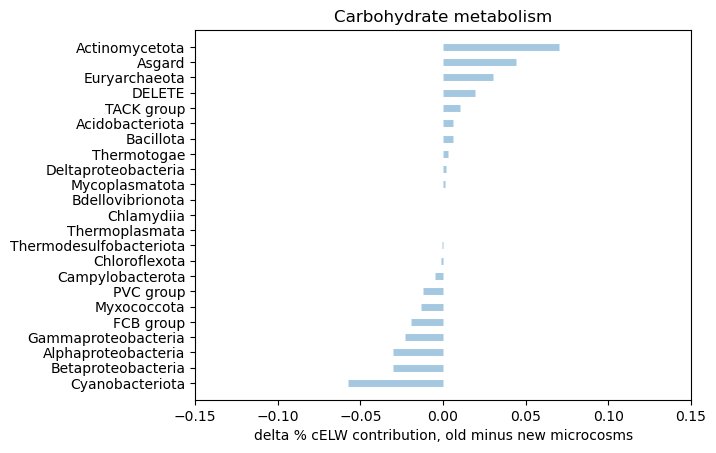

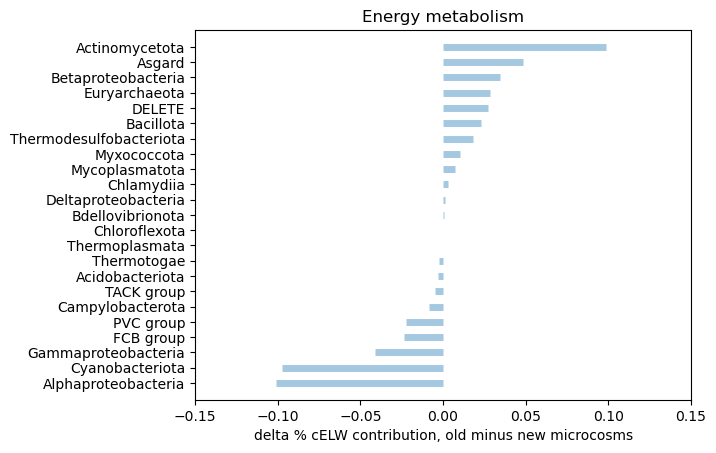

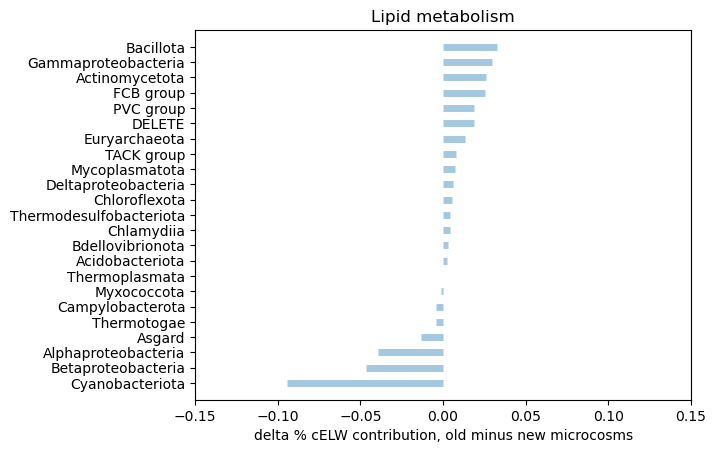

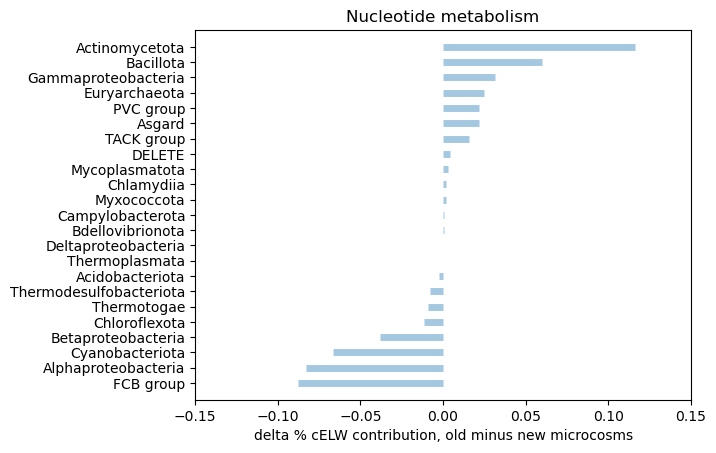

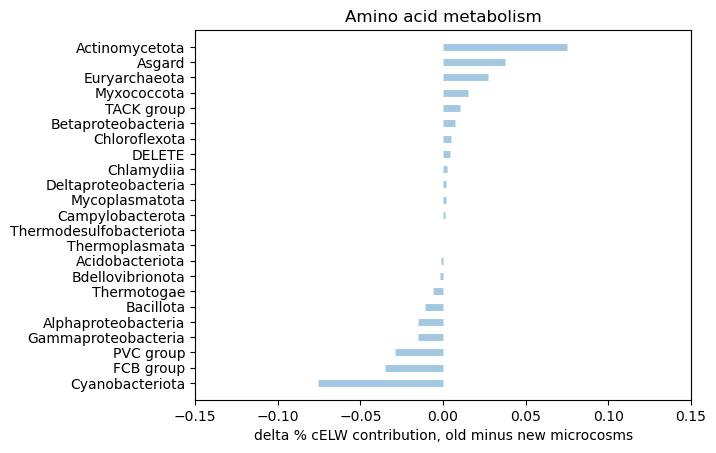

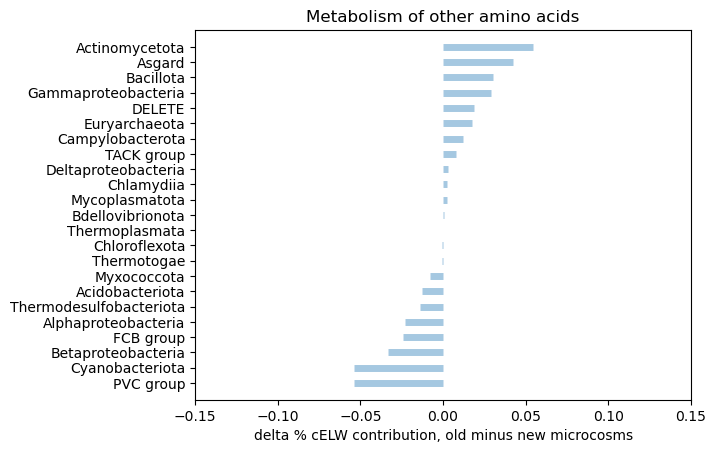

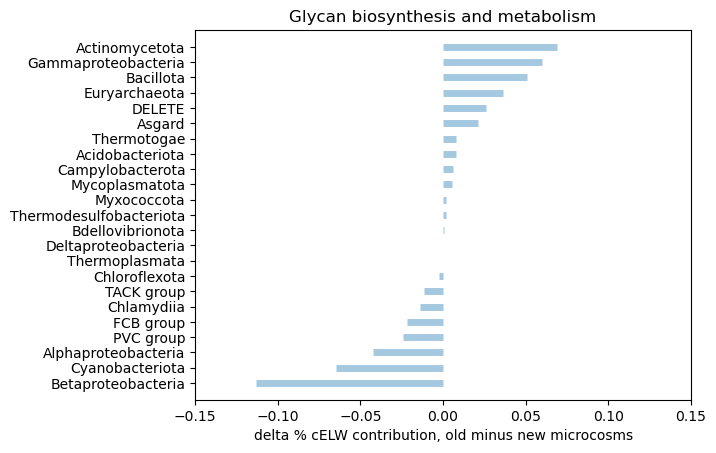

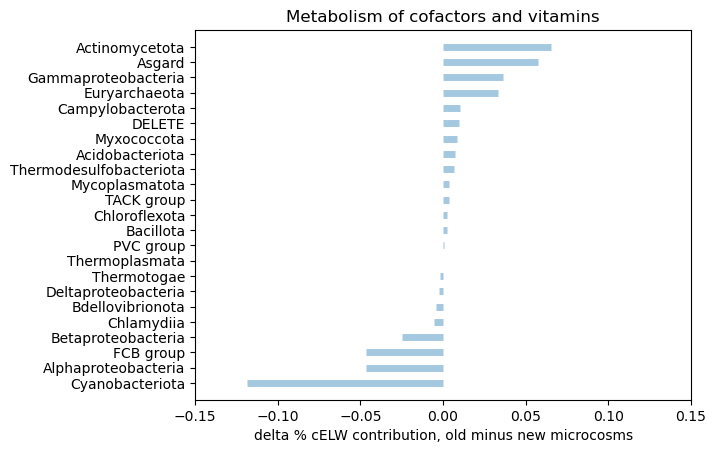

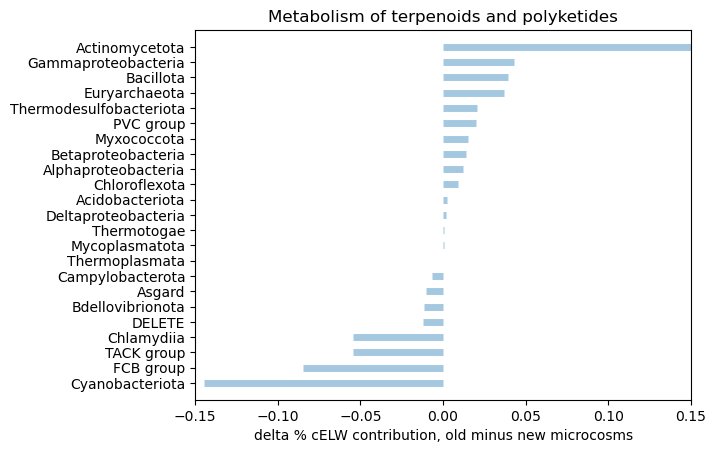

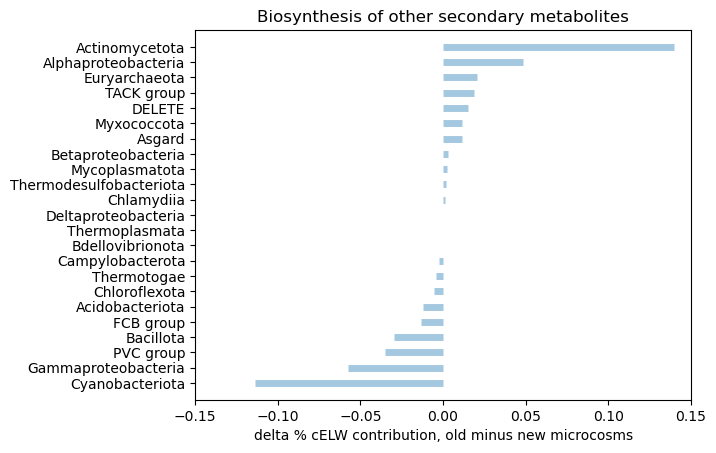

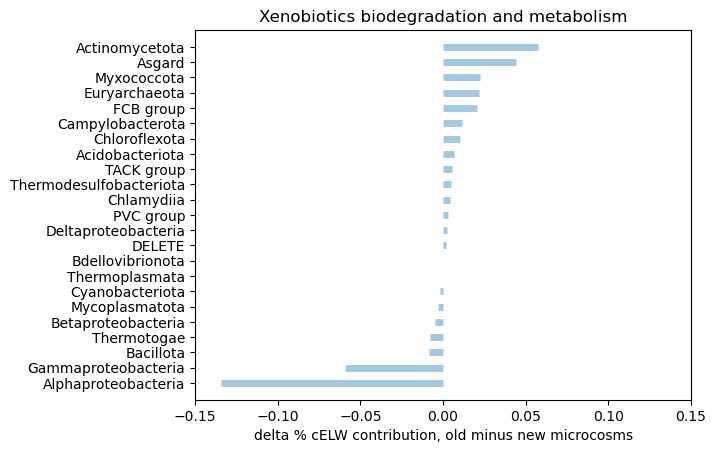

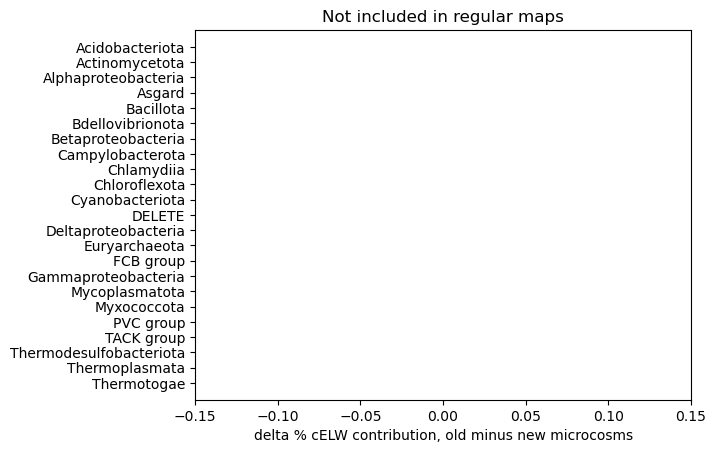

In [77]:
cELW_delta_df = cELW_delta_df.sort_index(ascending = False)
for colname in cELW_delta_df.columns:
    plt.figure()
    plt.hlines(y=cELW_delta_df.sort_values(colname).index, xmin=0, xmax=cELW_delta_df[colname].sort_values(), 
               alpha=0.4, linewidth=5) 
    plt.xlim(-.15,.15)
    plt.xlabel("delta % cELW contribution, old minus new microcosms")
    plt.title(f"{colname}")

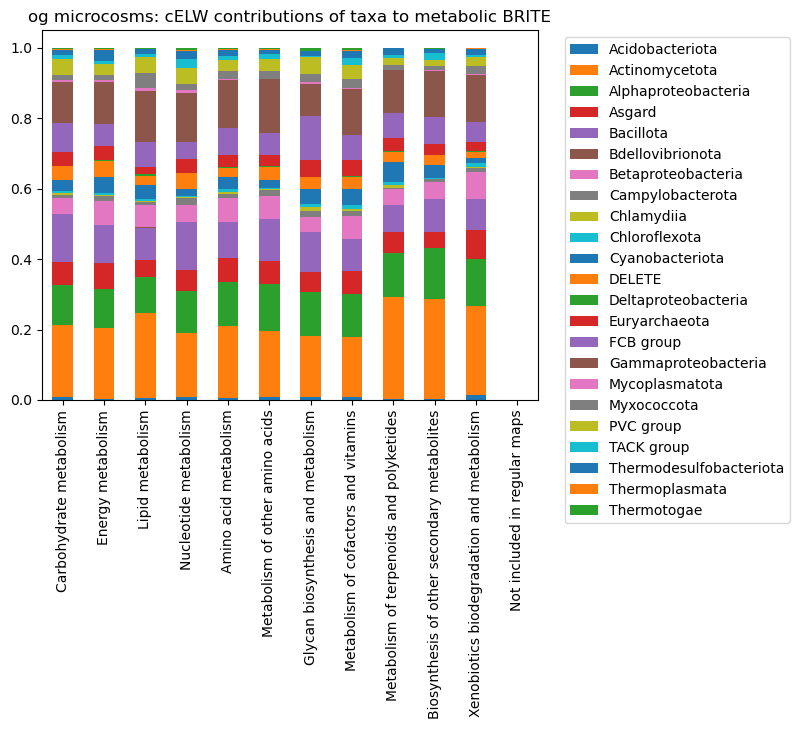

In [75]:
#cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)
cELW_df.T.plot(kind='bar', stacked=True,
        title='og microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

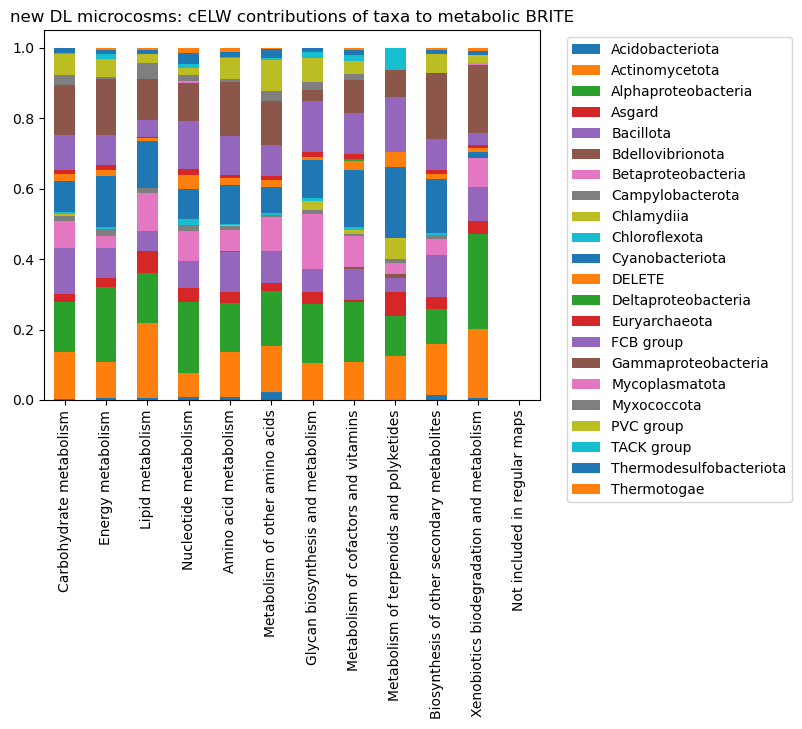

In [74]:
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_dl_df.T.plot(kind='bar', stacked=True,
        title='new DL microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [ ]:
cELW_dl_breakdowns["09109"].sort_values(), cELW_breakdowns["09109"].sort_values()

In [438]:
kogs = set(kog_brite[(kog_brite.brite_A == "09100")].kogid)
trees_filtered = tree_data_mapped[tree_data_mapped.Target.str.contains("|".join(kogs))]
trees_topscore = trees_filtered.sort_values(["Score"], ascending = False).drop_duplicates(["euk_clade_rep", "c-ELW"]).sort_values(["tree_name"])
trees_cELW = trees_topscore[trees_topscore["c-ELW"].between(.5,.999)]
#cELW_freq = trees_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_cELW.groupby("prok_taxa")["c-ELW"].sum())


trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs))]
trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
trees_dl_cELW = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,.999)]
#cELW_dl_freq = trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum())


In [439]:
trees_cELW

,euk_clade_rep,euk_clade_size,euk_clade_weight,euk_leaf_clade,euk_LCA,euk_scope,euk_scope_len,prok_clade_rep,prok_clade_size,prok_clade_weight,...,p-SH,p-SH_accept,c-ELW,c-ELW_accept,p-AU,p-AU_accept,Target,Score,Description,Pairwise_cov
tree_name,,,,,,,,,,,,,,,,,,,,,
AFR24247.1,EP00929P060973,5.0,0.294118,False,Dinophyceae,Dinophyceae,1.0,WP_174672495_1,3.0,0.250000,...,1.0,+,0.977,+,0.983,+,K01601,813.4,ribulose-bisphosphate carboxylase large chain ...,0.744235
CBJ26067.1,EP00429P006334,18.0,0.500000,False,Eukaryota,Metazoa|Ochrophyta|Dinophyceae|Rhodophyta|Cryp...,5.0,WP_083295369_1,561.0,0.116119,...,1.0,+,0.967,+,0.992,+,K01055,269.5,3-oxoadipate enol-lactonase [EC:3.1.1.24],0.900000
CBJ32131.1,EP00571P015022,11.0,0.523810,True,Ochrophyta,Ochrophyta,1.0,WP_143629077_1,37.0,0.203646,...,1.0,+,0.856,+,0.936,+,K01190,2378.1,beta-galactosidase [EC:3.2.1.23],0.974696
CBJ32131.1,EP00228P003081,134.0,0.716578,False,Eukaryota,Ochrophyta|Cryptophyceae|Haptista|Chlorophyta|...,10.0,WP_038034316_1,7.0,1.000000,...,1.0,+,0.620,+,0.859,+,K01190,2378.1,beta-galactosidase [EC:3.2.1.23],0.974696
CBJ32131.1,EP00446P049126,32.0,0.603774,False,Eukaryota,Choanoflagellata|Dinophyceae|Haptista,3.0,WP_162272301_1,190.0,0.198538,...,1.0,+,0.545,+,0.692,+,K01190,2378.1,beta-galactosidase [EC:3.2.1.23],0.974696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XP_789618.4,XP_009040467.1,6.0,1.000000,False,Eukaryota,Euglenida|Ochrophyta|Haptista,3.0,WP_148862123_1,4.0,0.173913,...,1.0,+,0.730,+,0.940,+,K07232,535.4,glutathione-specific gamma-glutamylcyclotransf...,0.947090
XP_789618.4,EP00404P042937,10.0,0.625000,False,Eukaryota,Choanoflagellata|Dinophyceae,2.0,WP_205743181_1,4.0,0.266667,...,1.0,+,0.728,+,0.890,+,K07232,535.4,glutathione-specific gamma-glutamylcyclotransf...,0.947090
XP_789618.4,WP_222615443_1,126.0,0.871655,False,cellular organisms,Fungi incertae sedis|Rhodophyta|Rhizaria|Chlor...,13.0,WP_148862123_1,4.0,0.173913,...,1.0,+,0.561,+,0.834,+,K07232,535.4,glutathione-specific gamma-glutamylcyclotransf...,0.947090


In [ ]:
ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
trees_cELW["EC"] = trees_cELW.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
trees_cELW = trees_cELW[trees_cELW.EC != None]

ec2cELWsum = {}
for ec in list(trees_cELW["EC"]):
    ec2cELWsum[ec] = trees_cELW[trees_cELW.EC == ec]["c-ELW"].sum()
trees_cELW["cELW_norm"] = trees_cELW["c-ELW"] / trees_cELW.EC.apply(lambda x: ec2cELWsum[x])

In [ ]:
kog2cELWsum = {}
for kog in kogs:
    kog2cELWsum[kog] = trees_cELW[trees_cELW.Target == kog]["c-ELW"].sum()
trees_cELW["cELW_norm2"] = trees_cELW["c-ELW"] / trees_cELW.Target.apply(lambda x: kog2cELWsum[x])

In [ ]:
trees_cELW[trees_cELW.prok_taxa== "Actinomycetota"].cELW_norm2.mean()

In [ ]:
cELW_freq = trees_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_cELW.groupby("prok_taxa")["c-ELW"].sum())
cELW_normfreq = trees_cELW.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW.groupby("prok_taxa")["cELW_norm"].sum())
cELW_dl_freq = trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum())


In [ ]:
len(trees_cELW[trees_cELW.prok_taxa == "Asgard"])

In [ ]:
len(trees_cELW[trees_cELW.prok_taxa == "Asgard"].EC.unique())

In [ ]:
cELW_freq

In [ ]:
(cELW_freq - cELW_dl_freq).sort_values()

In [ ]:
(cELW_normfreq - cELW_dl_freq).sort_values()

In [ ]:
# sandbox, microcosms_dl
#kogs_dl = set(module_data[module_data.CATEGORY_ID == "M00038"].KOGID) # glycolysis
#kogs_dl = set(kog_brite[(kog_brite.brite_C.str.contains("02000"))].kogid)
kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains("09101"))].kogid)


# tree_data_dl_mapped["KOG"] = tree_data_dl_mapped.KOGS.apply(lambda x: x.split("|"))
# translocases_indl = list(i for i in tree_data_dl_mapped[tree_data_dl_mapped.index.str.slice(start=0,stop=1) == "7"].KOG)
# translocases = []
# for lst in translocases_indl:
#     translocases += lst
# translocases = set(translocases)


trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))].sort_values("KOG")
trees_dl_cELW = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_dl_filtered.index.unique())
print(len(set(trees_dl_filtered.index)), len(set(trees_dl_cELW.index)))
microcosm_path = '/data/luojaa/eukgen/processing/microcosm_dl/'

In [ ]:
# # translocases
# tree_translocases_dl = tree_data_dl_mapped[tree_data_dl_mapped.index.str.slice(start=0,stop=1) == "7"]
# tree_translocases_dl["KOG"] = tree_translocases_dl.KOGS.apply(lambda x: x.split("|"))
# tree_translocases_dl_explode = tree_translocases_dl.explode("KOG")
# trees_translocases_dl_cELW = tree_translocases_dl_explode[tree_translocases_dl_explode["c-ELW"].between(.5,1)]
# print(len(set(tree_translocases_dl_explode.index)), len(set(trees_translocases_dl_cELW.index)))
# systems = iter(trees_translocases_dl_cELW.index.unique())

In [147]:
systems = iter(f[f.prok_taxa == 1].tree_name.iloc[100:].unique())


2.5.1.115
['homogentisate phytyltransferase']
['K09833']
System 2.5.1.115 has Eukaryotic clades ['EP00803P001340' 'EP00264P014993']
/data/luojaa/eukgen/processing/microcosm_dl/2.5.1.115/2.5.1.115.merged.fasta.muscle.treefile.annot
Tree has 33 leaves


alt.Chart(...)

,euk_clade_rep,prok_clade_rep,prok_taxa,dist,top_dist,raw_stem_length,median_euk_leaf_dist,stem_length,logL,deltaL,...,p-KH_accept,p-SH,p-SH_accept,c-ELW,c-ELW_accept,p-AU,p-AU_accept,confidence,KOGS,description
tree_name,,,,,,,,,,,,,,,,,,,,,
2.5.1.115,EP00803P001340,WP_224340883_1,Cyanobacteriota,2.012413,1.0,1.022288,1.013544,1.008627,-1.0,-1.0,...,+,1.0,+,1.0,+,1.0,+,0.9609,K09833,homogentisate phytyltransferase
2.5.1.115,EP00264P014993,WP_224340883_1,Cyanobacteriota,1.103491,2.0,0.049818,1.870999,0.026627,-1.0,-1.0,...,+,1.0,+,1.0,+,1.0,+,0.9733,K09833,homogentisate phytyltransferase


alt.VConcatChart(...)

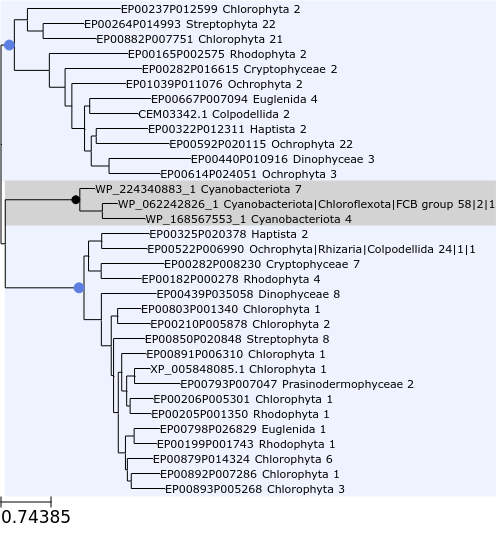

In [154]:
microcosm_path = '/data/luojaa/eukgen/processing/microcosm_dl/'
system = next(systems)
#system = "EP01041P032404"
print(system)


# data = tree_data_mapped.loc[[system]].sort_values(by=['Score', 'c-ELW'], ascending=False)
# kogs, functions = data.Target, data.Description
# print(dict(zip(kogs, functions)))
data = tree_data_dl_mapped.loc[[system]].sort_values(by=['c-ELW'], ascending=False)
print(data.description.unique())
print(data.KOGS.unique())
    
clades = data.euk_clade_rep.unique()
print(f'System {system} has Eukaryotic clades {clades}')

clade = clades[0]

plot_data = data[data.euk_clade_rep == clade]

dist_bar = alt.Chart(data, title=f'{system}: {clade}').mark_bar().encode(
    x = alt.X('prok_taxa', sort=None, axis=alt.Axis(labelAngle=-45)),
    y = alt.Y('top_dist'),
    color = alt.Color('prok_taxa:O'),
    tooltip = alt.Tooltip(['top_dist', 'prok_clade_weight', 'prok_clade_size', 'prok_clade_rep', 'prok_leaf_clade'])
)

print(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
annot_tree, tree_img = color_tree(tree, view_in_notebook=True)


from core_functions.altair_plots import plot_alignment
aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'

#leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
leaf_names = [leaf.name for leaf in tree.get_leaves()]

plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)

\
print(f'Tree has {len(leaf_names)} leaves')
display(dist_bar)
display(data.drop(["euk_clade_size","euk_clade_weight","euk_leaf_clade","prok_clade_size","prok_clade_weight","prok_leaf_clade"], axis=1))#.iloc[:,[0,4,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]])
#display(pd.DataFrame(CDD_annot.loc[system]))
display(plot)
display(tree_img)

In [ ]:
header_mapping_annot[header_mapping_annot.index.isin(['XP_031501475.1',
 'XP_002275543.1',
 'XP_012444669.1',
 'XP_012452889.1',
 'XP_026405603.1',
 'XP_026413187.1',
 'XP_002283744.2',
 'XP_006593399.1',
 'XP_012462945.1',
 'NP_175758.2',
 'XP_031500398.1',
 'PTQ49663.1',
 'XP_002108785.1',
 'XP_030844904.1',
 'XP_009051386.1',
 'XP_011405752.1',
 'XP_020048970.1',
 'XP_007709237.1',
 'XP_008908753.1',
 'OAC99004.1',
 'XP_664445.1',
 'KAA6408464.1',
 'XP_018192209.1'])]

### filter pathways and look at top sister clades

In [ ]:
# number of microcosms with this pathway
len(set(trees_filtered.index))


In [ ]:
# all sister clades
trees_filtered.sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

In [ ]:
# all sister clades with high c-ELW
trees_sorted[trees_sorted["c-ELW"].between(.5,.999)].sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

In [ ]:
ribosome_lsu = ['K02925',
'K02930',
'K02932',
'K02934',
'K02937',
'K02936',
'K02938',
'K02940',
'K02866',
'K02865',
'K02868',
'K02870',
'K02873',
'K02872',
'K02875',
'K02877',
'K02880',
'K02883',
'K02882',
'K02885',
'K02889',
'K02891',
'K02894',
'K02893',
'K02896',
'K02898',
'K02901',
'K02900',
'K02903',
'K02905',
'K02908',
'K02910',
'K02912',
'K02915',
'K02918',
'K02917',
'K02920',
'K02922',
'K02921',
'K02923',
'K02924',
'K02927',
'K02928',
'K02929',
'K02941',
'K02942',
'K02943']

initiation = """K02519
K02520
K03113
K03236
K03237
K03238
K03239
K03240
K03241
K03242
K03243
K03245
K03246
K03247
K03248
K03249
K03250
K03251
K03252
K03253
K03254
K03255
K03257
K03258
K03259
K03260
K03261
K03262
K03263
K03264
K03680
K03754
K06158
K06184
K13025
K15026
K15027
K15028
K15029
K15030
K15908
K18995
K19036
K23325
K24086""".split("\n")
elongation = """K00586
K02355
K02357
K02358
K03231
K03232
K03233
K03234
K03235
K03833
K06927
K07561
K15410
K15455
K17866
K17867
K17868
K17878
K19539
K21803
K22696
K22855
K22856
K22857
K24887
K25166""".split("\n")
release = """K03265
K03267
K15031
K15033
K02835
K02838
K02493
K19589
K15448
K01056
K04794""".split("\n")

prokaryotic_transfact = """K01056
K02355
K02356
K02357
K02358
K02493
K02518
K02519
K02520
K02835
K02836
K02837
K02838
K02839
K03833
K04568
K04794
K09890
K09906
K15034
K19810""".split("\n")

In [ ]:
set(prokaryotic_transfact).difference(set(initiation + elongation + release))

In [ ]:
len(prokaryotic_transfact)